In [1]:
import lithops
from lidarpartitioner import create_partitions
import os
import shutil
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
bucketPath = 'cos://lithops-testing/LimitTest/'
bucketName = 'lithops-testing'
partition_size = 500_000
buffer_size = 5

In [3]:
def get_process_cost(fexec):
    import pandas as pd
    df = pd.read_csv(fexec.log_path)
    cost = float(df[df["Job_ID"] == "Summary"]["Cost"])
    return cost

In [4]:
def partitionCloudFile(obj, ibm_cos):
    #Make sure the file doesn't exist
    if os.path.exists("/tmp/lasfile.las"):
        os.remove("/tmp/lasfile.las")

    #Download LIDAR file
    ibm_cos.download_file(bucketName, obj.key, '/tmp/lasfile.las')
        
    #Make sure folder is empty
    if os.path.exists('/partitions'):
        shutil.rmtree('/partitions')

    #Create folder to store partitions
    os.makedirs('/partitions')

    #Create partitions
    create_partitions('/tmp/lasfile.las', '/partitions', partition_size, buffer_size)

    #Upload partitions to the Cloud
    for file in os.listdir("/partitions"):
        path = "/partitions/" + file
        destinationPath = "partitions/" + obj.key + "/" + file
        ibm_cos.upload_file(path, bucketName, destinationPath)
        
    return os.path.getsize("/tmp/lasfile.las")/(1024*1024)

In [5]:
if __name__ == "__main__":
    fexec = lithops.FunctionExecutor(runtime='arnaugabriel/lithopspartitioner:1.0')
    fexec.map(partitionCloudFile, bucketPath)
    sizes = fexec.get_result()

2022-06-09 11:36:10,425 [INFO] lithops.config -- Lithops v2.6.0
2022-06-09 11:36:10,529 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: us-east
2022-06-09 11:36:10,530 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: eu-de - Namespace: lithops_testing_functions
2022-06-09 11:36:10,531 [INFO] lithops.invokers -- ExecutorID 10b57b-0 | JobID M000 - Selected Runtime: arnaugabriel/lithopspartitioner:1.0 - 2048MB
2022-06-09 11:36:11,803 [INFO] lithops.invokers -- ExecutorID 10b57b-0 | JobID M000 - Starting function invocation: partitionCloudFile() - Total: 118 activations
2022-06-09 11:36:11,873 [INFO] lithops.invokers -- ExecutorID 10b57b-0 | JobID M000 - View execution logs at /tmp/lithops/logs/10b57b-0-M000.log
2022-06-09 11:36:11,877 [INFO] lithops.wait -- ExecutorID 10b57b-0 - Getting results from 118 function activations


    0%|          | 0/118  

2022-06-09 11:38:21,905 [INFO] lithops.executors -- ExecutorID 10b57b-0 - Cleaning temporary data


KPIs

In [6]:
    fexec.plot(dst="plots/partition")

2022-06-09 11:38:22,233 [INFO] lithops.executors -- ExecutorID 10b57b-0 - Creating execution plots


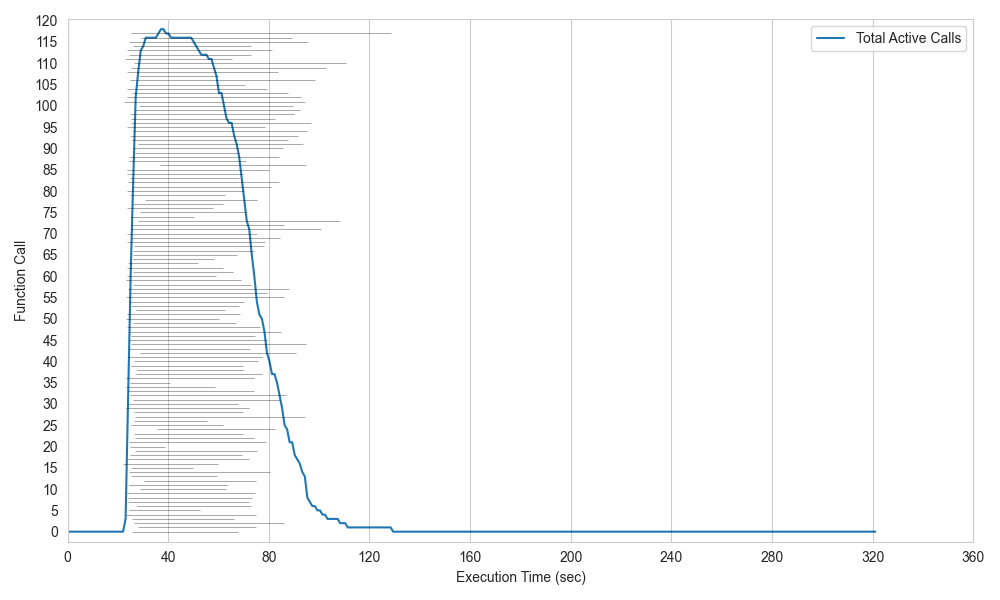

In [7]:
    Image(filename="plots/partition_histogram.png")

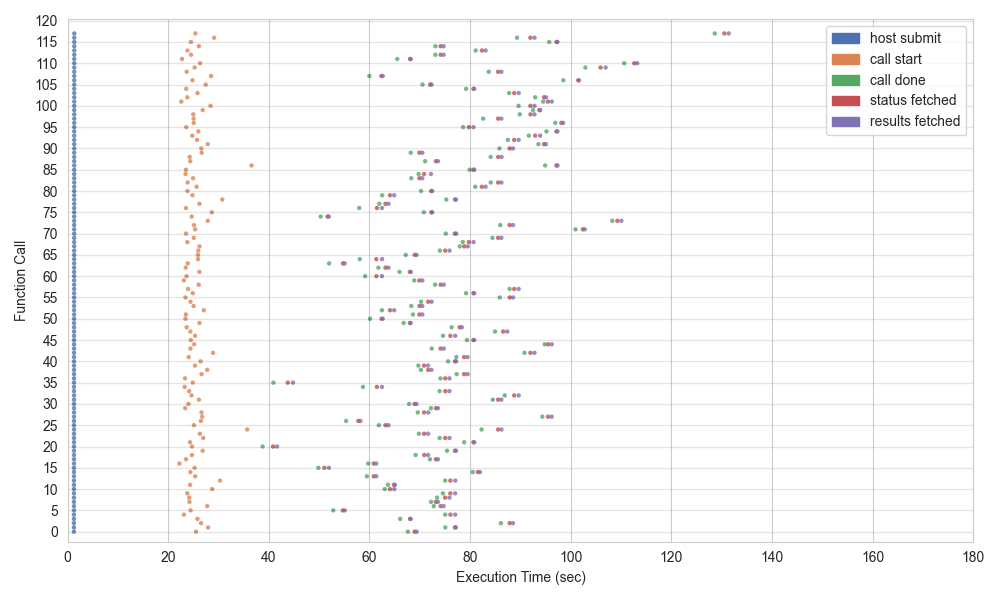

In [8]:
    Image(filename="plots/partition_timeline.png")

Data size

In [9]:
    data_size = sum(sizes)
    print(f"Data size: {data_size} MB")

Data size: 2399.9462060928345 MB


KPI: Cost

In [10]:
    fexec.job_summary()
    pd.read_csv(fexec.log_path)

    cost_interpolation = get_process_cost(fexec)
    print(f"The experiment cost ${cost_interpolation:.4f}.")

2022-06-09 11:38:22,557 [INFO] lithops.executors -- View log file logs at /tmp/lithops/logs/2022-06-09_11:38:22.csv


The experiment cost $0.2029.


KPI: Throughput

In [11]:
    tstamps = set()
    for future in fexec.futures:
        for key in future.stats.keys():
            if key.endswith("tstamp"):
                tstamps.add(future.stats[key])

    duration = max(tstamps) - min(tstamps)
    print("Duration: " + str(duration) + " seconds")

    throughput_interpolation = data_size / duration

    print(f"Throughput: {throughput_interpolation} MB/s")

Duration: 131.37153005599976 seconds
Throughput: 18.26838893533332 MB/s
